# Hello World!

Here's an example notebook with some documentation on how to access CMIP data.

In [1]:
import s3fs
import xarray as xr
import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022/Remy/')

['escience2022/Remy/.keep',
 'escience2022/Remy/.wget-20221102193645.sh.status',
 'escience2022/Remy/.wget-20221102193729.sh.status',
 'escience2022/Remy/.wget-20221102193735.sh.status',
 'escience2022/Remy/.wget-20221102193742.sh.status',
 'escience2022/Remy/Era5',
 'escience2022/Remy/dl_era5_hus.py',
 'escience2022/Remy/dl_era5_wind.py',
 'escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_19500101-19591231.nc',
 'escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_19600101-19691231.nc',
 'escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_19700101-19791231.nc',
 'escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_19800101-19891231.nc',
 'escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_19900101-19991231.nc',
 'escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_20000101-20091231.nc',
 'escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_20100101-20141231.nc',
 'escie

In [2]:
s3path = 'escience2022/Remy/od550aer_AERday_NorESM2-LM_ssp370_r1i1p1f1_gn_20710101-20801231.nc'

In [3]:
esacci = xr.open_dataset(s3.open(s3path))
esacci

<xarray.Dataset>
Dimensions:     (time: 3650, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time        (time) object 2071-01-01 12:00:00 ... 2080-12-31 12:00:00
  * lat         (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    wavelength  float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) object ...
    lat_bnds    (lat, bnds) float64 ...
    lon_bnds    (lon, bnds) float64 ...
    od550aer    (time, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               ScenarioMIP AerChemMIP
    branch_method:             Hybrid-restart from year 2015-01-01 of historical
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     60225.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               od550aer
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/e78f7ceb-b72e-462c-ae68-0503588d1764

`intake-esm` is build on top of [pandas](https://pandas.pydata.org/pandas-docs/stable). It is possible to view the `pandas.DataFrame` as follows.

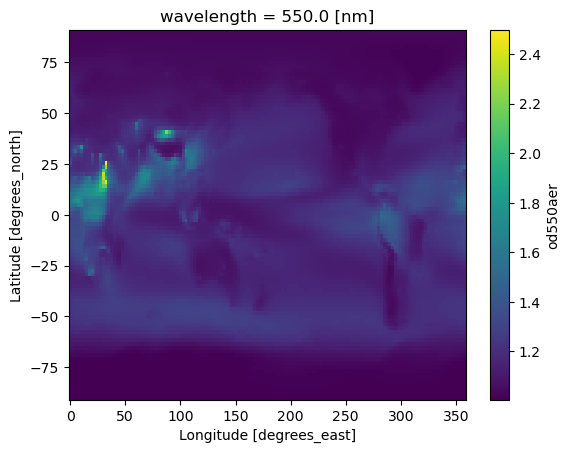

In [5]:
xr.plot.pcolormesh(esacci.mean(dim='time').od550aer)

It is possible to interact with the `DataFrame`; for instance, we can see what the "attributes" of the datasets are by printing the columns.

In [ ]:
col.df.columns

### Search and discovery

#### Finding unique entries
Let's query the data to see what models ("source_id"), experiments ("experiment_id") and temporal frequencies ("table_id") are available.

In [ ]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

#### Searching for specific datasets

Let's find all the dissolved oxygen data at annual frequency from the ocean for the `historical` and `ssp585` experiments.

In [ ]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Oyr', variable_id='o2', grid_label='gn')
cat.df

It might be desirable to get more specific. For instance, we may want to select only the models that have *both* `historical` and `ssp585` data. We coud do this as follows.

In [ ]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical', 'ssp585']:
    query = dict(experiment_id=experiment_id, table_id='Oyr', 
                 variable_id='o2', grid_label='gn')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

# ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
models = models - {'CESM2-WACCM', 'CESM2'}

models = list(models)
models

In [ ]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='Oyr', 
                 variable_id='o2', grid_label='gn', source_id=models)
cat.df

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [ ]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                cdf_kwargs={'chunks': {}})

`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [ ]:
dset_dict.keys()

We can access a particular dataset as follows.

In [ ]:
dset_dict['CMIP.CCCma.CanESM5.historical.Oyr.gn']

### More advanced queries

As motivation for diving into more advanced manipulations with `intake-esm`, let's consider the task of getting access to grid information in the `Ofx` table_id.

In [ ]:
cat_fx = col.search(experiment_id=['historical', 'ssp585'], source_id=models, table_id='Ofx', grid_label='gn')
cat_fx.df

This, however, comes with lots of redundant information.

Additionally, it may be necessary to do more targeted manipulations of the search. For instance, we've found a handful of corrupted files on `glade` and might need to work around loading these. 

As an illustration of this, in the code below, we specify a list of to queries (in this case one) to eliminate.

In [ ]:
import numpy as np

# specify a list of queries to eliminate
corrupt_data = [dict(variable_id='areacello', source_id='IPSL-CM6A-LR',
                     experiment_id='historical', member_id='r2i1p1f1')
               ]


# copy the dataframe 
df = cat_fx.df.copy()

# eliminate data
for elim in corrupt_data:
    condition = np.ones(len(df), dtype=bool)
    for key, val in elim.items():
        condition = condition & (df[key] == val)
    df = df.loc[~condition]
df    

We then drop duplicates.

In [ ]:
df.drop_duplicates(subset=['source_id', 'variable_id'], inplace=True)

Now, since we've only retained one ensemble member, we need to eliminate that column. If we omit this step, `intake-esm` will throw an error, complaining that different variables are present for each ensemble member. Setting the `member_id` column to NaN precludes attempts to join along the ensemble dimension.

After this final manipulation, we copy the `DataFrame` back to the collection object and proceed with loading the data.

In [ ]:
df['member_id'] = np.nan
cat_fx.df = df

In [ ]:
fx_dsets = cat_fx.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})

In [ ]:
fx_dsets.keys()

In [ ]:
for key, ds in fx_dsets.items():
    print(ds.data_vars)

## Demonstrate how spin-up a dask cluster

If you expect to require Big Data capabilities, here's how you spin up a [dask](https://dask.org) cluster using [dask-jobqueue](https://dask-jobqueue.readthedocs.io/en/latest/).

The syntax is different if on an NCAR machine versus the cloud.

In [ ]:
if util.is_ncar_host():
    from ncar_jobqueue import NCARCluster
    cluster = NCARCluster(project='UCGD0006')
    cluster.adapt(minimum_jobs=1, maximum_jobs=10)
else:
    from dask_kubernetes import KubeCluster
    cluster = KubeCluster()
    cluster.adapt(minimum=1, maximum=10)
cluster

In [ ]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client